In [1]:
import numpy as np

import torch
import torch.nn as nn

import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize

from matplotlib import pyplot as plt

from MyGenerator import MyGenerator
from MyDiscriminator import MyDiscriminator

from hw4_utils import load_MNIST

np.random.seed(2023)

batch_size = 128

normalize_vals = (0.5, 0.5)

# load MNIST dataset
train_dataset, test_dataset, train_loader, test_loader = load_MNIST(batch_size, normalize_vals)

/home/kimsh96453/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random

In [17]:
class MyGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(MyGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, x):
        z = torch.randn(128, 128)
        fake = self.generator.forward(z)

        real_output = self.discriminator.forward(x)
        fake_output = self.discriminator.forward(fake)
        return fake_output, real_output, fake

    def fit(self, train_loader, threshold , max_epochs):
        gen_optim = torch.optim.Adam(self.generator.parameters(), lr = 0.0002)
        disc_optim = torch.optim.Adam(self.discriminator.parameters(), lr = 0.0002)
        d_loss_list = []
        g_loss_list = []
        epochs = []
        fake_imgs = torch.empty((1, 784))
        selected_imgs = []
        for i in range(max_epochs):
            d_loss = 0
            g_loss = 0
            for j, (real_features, _) in enumerate(train_loader):
                real_features, _ = (real_features, _)
                real_features = real_features.view(-1, 784)
                fake_output, real_output, fake_images = self.forward(real_features) 

                self.discriminator.zero_grad()
                d_loss = nn.BCELoss()(real_output, torch.ones_like(real_output)) + nn.BCELoss()(fake_output, torch.zeros_like(fake_output))
                d_loss.backward(retain_graph = True)
                disc_optim.step()
                d_loss += d_loss.item()

                self.generator.zero_grad()
                re_fake_output, _, __ = self.forward(real_features)
                g_loss = nn.BCELoss()(re_fake_output, torch.ones_like(fake_output))
                g_loss.backward()
                gen_optim.step()
                g_loss += g_loss.item()

                sel_img = fake_images
            fake_imgs = torch.vstack((fake_imgs, sel_img))
            rand_ind = random.sample(range(fake_images.shape[0]), k = 1)
            img_from_epoch = fake_imgs[rand_ind]
            selected_imgs.append(img_from_epoch)
            self.selected_imgs = selected_imgs

            d_loss = d_loss.item()
            g_loss = g_loss.item()
            d_loss_list.append(d_loss)
            g_loss_list.append(g_loss)
            epochs.append(i+1)
            print(i+1, ": ", {"d_loss": round(d_loss,4), "g_loss": round(g_loss,4)})

            if i > 10:
                d_last_five = d_loss_list[-5:]
                d_last_five_diff = [np.abs(t - s) for s, t in zip(d_last_five, d_last_five[1:])]
                g_loss_five = g_loss_list[-5:]
                g_last_five_diff = [np.abs(t - s) for s, t in zip(g_loss_five, g_loss_five[1:])]
                
                if i == 11:
                    plot_df = np.column_stack((epochs, d_loss_list, g_loss_list))
                    plt.plot(plot_df[:, 0], plot_df[:, 1], color = 'orange')
                    plt.plot(plot_df[:, 0], plot_df[:, 2], color = 'blue')
                    plt.xticks(np.arange(min(plot_df[:, 0]), max(plot_df[:, 0]), 5.0))
                    #plt.yticks(np.arange(min(plot_df[:, 1]), max(plot_df[:, 1])+0.01, 0.01))
                    plt.legend(['D', 'G'])
                    plt.savefig('imgs/q3/hw4_q3_train_loss')
                    break

    def img_sel(self):
        rand_five = random.sample(range(len(self.selected_imgs)), k = 5)
        epochs = [x+1 for x in rand_five]
        reshape_di = int(np.sqrt(self.selected_imgs[0].shape[1]))
        for i in range(len(rand_five)):
            img_to_plot = self.selected_imgs[rand_five[i]]
            img_to_plot = img_to_plot.view(-1, reshape_di, reshape_di)
            img_to_plot = img_to_plot.detach().numpy()
            img_to_plot = np.reshape(img_to_plot, (reshape_di, reshape_di))
            plt.imshow(img_to_plot, 'gray')
            plt.savefig('imgs/q3/hw4_q3_fake_imgs_epoch ' + str(epochs[i]))

1 :  {'d_loss': 0.5801, 'g_loss': 7.8659}
2 :  {'d_loss': 0.1302, 'g_loss': 8.9581}
3 :  {'d_loss': 0.4351, 'g_loss': 7.3891}
4 :  {'d_loss': 0.2355, 'g_loss': 7.3498}
5 :  {'d_loss': 0.1708, 'g_loss': 9.3744}
6 :  {'d_loss': 0.3477, 'g_loss': 7.8745}
7 :  {'d_loss': 0.2426, 'g_loss': 7.0833}
8 :  {'d_loss': 0.7298, 'g_loss': 5.5585}
9 :  {'d_loss': 0.8525, 'g_loss': 4.9946}
10 :  {'d_loss': 1.0928, 'g_loss': 4.6186}
11 :  {'d_loss': 1.1732, 'g_loss': 4.2285}
12 :  {'d_loss': 0.8165, 'g_loss': 4.0442}


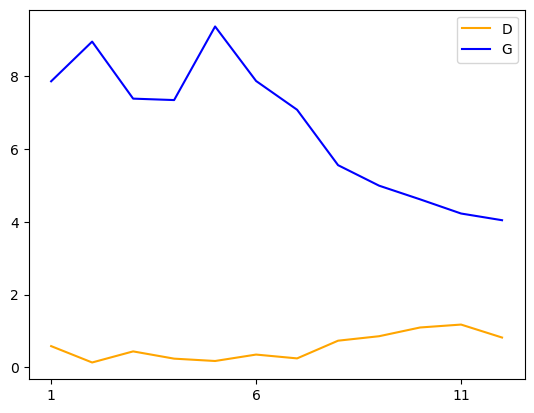

In [18]:
gen = MyGenerator()
disc = MyDiscriminator(input_size = 784)
gan = MyGAN(generator=gen, discriminator=disc)

gan.fit(train_loader=train_loader, threshold=0.25, max_epochs=50)


In [19]:
gan.img_sel()

TypeError: view(): argument 'size' must be tuple of SymInts, but found element of type numpy.float64 at pos 2

In [13]:
ind = random.sample(range(len(list)), k = 5)

In [16]:
t = list[0]

In [23]:
d = int(np.sqrt(t.shape[1]))

In [24]:
t = list[1]
t = t.view(-1, 28, 28)
t = t.detach().numpy()
t = np.reshape(t, (d, d))

[2, 6, 11, 8, 5]

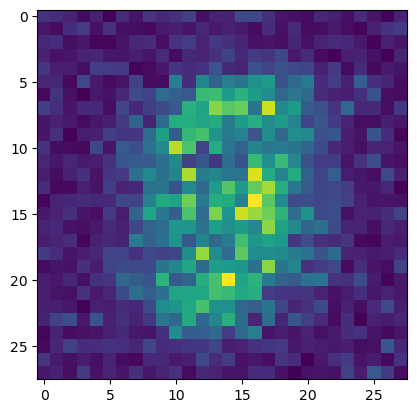

In [10]:
plt.imshow(t)
plt.show()

In [11]:
ind, five_img = gan.img_sel()


torch.Size([13, 784])


In [15]:
five_img = five_img.view(-1, 28, 28)
five_img = five_img.detach().numpy()

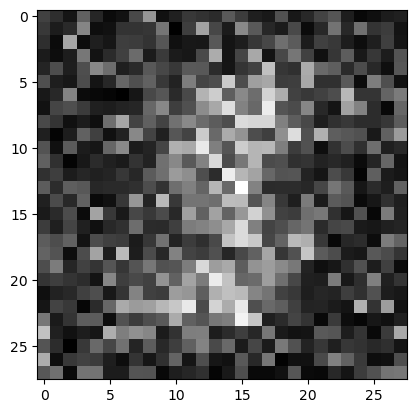

In [18]:
plt.imshow(five_img[4], 'gray')
plt.show()

In [5]:
gen = MyGenerator()
disc = MyDiscriminator(input_size=784)

In [6]:
fake = gen.forward(z)
real = disc.forward(real_features)
fake_output = disc.forward(fake)

In [7]:
d_loss = nn.BCELoss()(real, torch.ones_like(real)) + nn.BCELoss()(fake_output, torch.zeros_like(fake_output))
g_loss = nn.BCELoss()(fake_output, torch.ones_like(fake_output))

In [8]:
gen_optim = torch.optim.Adam(gen.parameters(), lr = 0.0002)
disc_optim = torch.optim.Adam(disc.parameters(), lr = 0.0002)

In [25]:
def forward(x):
    z = torch.randn(128, 128)
    fake = gen.forward(z)

    real_output = disc.forward(x)
    fake_output = disc.forward(fake)
    return fake_output, real_output, fake

In [15]:
l = [1.6519, 1.8667, 2.0306, 1.9813,1.7049]
diff = [np.abs(t - s) for s, t in zip(l, l[1:])]

In [26]:
fo, ro, f = forward(real_features)

In [29]:
sel_f = f[ind]

In [30]:
et = fake_imgs = torch.empty((1, 784))

In [32]:
et = torch.vstack((et, sel_f))

In [45]:
et = torch.squeeze(et)

In [33]:
etnp = et.detach().numpy()

In [38]:
d = torchvision.transforms.ToTensor(etnp[1])

TypeError: ToTensor.__init__() takes 1 positional argument but 2 were given

In [46]:
d = np.reshape(d, (28, 28))

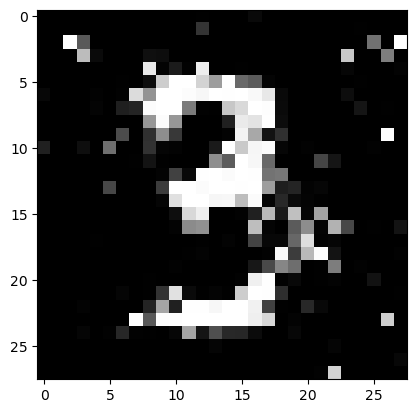

In [47]:
plt.imshow(d, 'gray')
plt.show()